train autoencoder using 1DCNN roi finder

In [1]:
import sys
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
wireplane = "U"
np.random.seed(42)
path = 'processed_data/'
filenames = [path+f for f in listdir(path) if (isfile(join(path, f)) and wireplane in f)]
filenames

['processed_data/mean_U.npy',
 'processed_data/std_U.npy',
 'processed_data/x_test_U.npy',
 'processed_data/x_train_U.npy',
 'processed_data/y_test_AE_U.npy',
 'processed_data/y_test_ROI_U.npy',
 'processed_data/y_train_AE_U.npy',
 'processed_data/y_train_ROI_U.npy']

In [3]:
x_test = np.load(filenames[2])
x_train = np.load(filenames[3])
y_test = np.load(filenames[4])
y_train = np.load(filenames[6])

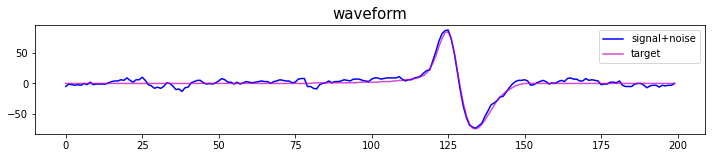

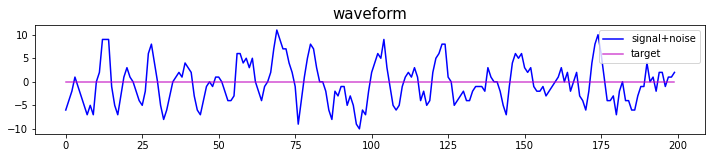

In [4]:
for idx in range(4,6):
    fig, (ax1) = plt.subplots(figsize=(12, 2), facecolor='white')
    ax1.plot(x_train[idx],color='blue', label='signal+noise')
    ax1.plot(y_train[idx],color='m',alpha=0.7, label='target')
    ax1.set_title("waveform", fontsize=15)
    ax1.legend()

    plt.show()

In [5]:
mean = x_train.mean()
std = x_train.std()
np.save("latest_models/mean_AE_"+wireplane+"_nu", mean)
np.save("latest_models/scale_AE_"+wireplane+"_nu", std)

In [6]:
x_train_scaled = (x_train-mean)/std
x_test_scaled = (x_test-mean)/std

In [7]:
y_train_scaled = []
for i in range(len(y_train)):
    if sum(y_train[i]) == 0:
        y_train_scaled.append(y_train[i])
    else:
        scaled = (y_train[i]-mean)/std
        y_train_scaled.append(scaled)
y_train_scaled = np.array(y_train_scaled)


In [8]:
y_test_scaled = []
for i in range(len(y_test)):
    if sum(y_test[i]) == 0:
        y_test_scaled.append(y_test[i])
    else:
        scaled = (y_test[i]-mean)/std
        y_test_scaled.append(scaled)
y_test_scaled = np.array(y_test_scaled)


-1.2418376635852035


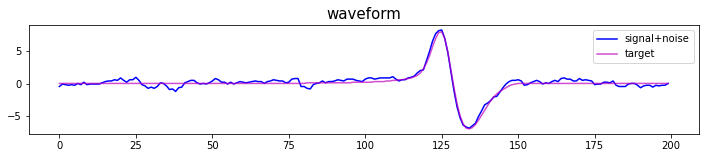

0.0


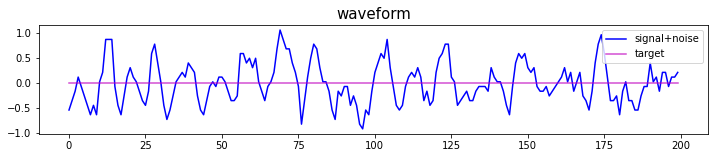

In [9]:
for idx in range(4,6):
    fig, (ax1) = plt.subplots(figsize=(12, 2), facecolor='white')
    ax1.plot(x_train_scaled[idx],color='blue', label='signal+noise')
    ax1.plot(y_train_scaled[idx],color='m',alpha=0.7, label='target')
    ax1.set_title("waveform", fontsize=15)
    ax1.legend()
    print(sum(y_train_scaled[idx]))
    plt.show()

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dropout, Dense,Flatten, AveragePooling1D
from tensorflow.keras.layers import Input,  UpSampling1D
from tensorflow.keras.models import Model
#from keras import backend as K

In [11]:
from tensorflow.keras.models import load_model
model = load_model('latest_models/model_' + wireplane + 'plane_nu.h5')

In [12]:
for i,layer in enumerate(model.layers):
  print(i,layer.name)

0 conv1d
1 max_pooling1d
2 conv1d_1
3 max_pooling1d_1
4 dropout
5 conv1d_2
6 global_max_pooling1d
7 dropout_1
8 flatten
9 wavrec_out


In [13]:
time_periods = 200
input_wave = Input(shape=(x_train_scaled.shape[1], 1)) 
x = Conv1D(filters=16, kernel_size=3, strides=2, activation = "relu", weights=model.layers[0].get_weights() , input_shape=(time_periods,1))(input_wave)
x = MaxPooling1D(pool_size=2)(x)
 
#second convolutional block
x = Conv1D(filters=32, kernel_size=5, strides=2, weights=model.layers[2].get_weights(), activation = "relu", )(x)
x = MaxPooling1D(pool_size=2)(x)

encoded = Conv1D(filters=64, kernel_size=9, weights=model.layers[5].get_weights(), activation = "relu")(x)


x = Conv1D(filters=64, kernel_size=9, padding = "same", activation = "relu")(encoded)
x = UpSampling1D(4)(x)

x = Conv1D(filters=32, kernel_size=5, padding = "same", activation = "relu")(x)
x = UpSampling1D(3)(x)

x = Conv1D(filters=16, kernel_size=3,  activation = "relu")(x)
x = UpSampling1D(6)(x)

decoded = Conv1D(filters=1, kernel_size=5,  activation = "linear")(x)



autoencoder = Model(input_wave, decoded)

In [14]:
for i,layer in enumerate(autoencoder.layers):                                      
  print(i,layer.name)

0 input_1
1 conv1d
2 max_pooling1d
3 conv1d_1
4 max_pooling1d_1
5 conv1d_2
6 conv1d_3
7 up_sampling1d
8 conv1d_4
9 up_sampling1d_1
10 conv1d_5
11 up_sampling1d_2
12 conv1d_6


In [15]:
for layer in autoencoder.layers[:6]:                                               
    layer.trainable=False                                                          
for layer in autoencoder.layers[6:]:                                               
    layer.trainable=True                                                           
autoencoder.compile(optimizer='adam', loss='mse')

In [16]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 99, 16)            64        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 16)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 23, 32)            2592      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 3, 64)             18496 

In [17]:
%%time
history = autoencoder.fit(x_train_scaled,                                                              
                    y_train_scaled,                                                            
                    batch_size=1024,                                              
                    epochs=100,                                                      
                    callbacks=None, # callbacks=callbacks_list,                         
                    validation_split=0.2, shuffle=False,                                               
                    verbose=1)   

Epoch 1/100
79/79 [==============================] - 4s 12ms/step - loss: 0.5594 - val_loss: 0.3425
Epoch 2/100
79/79 [==============================] - 1s 9ms/step - loss: 0.2540 - val_loss: 0.1813
Epoch 3/100
79/79 [==============================] - 1s 9ms/step - loss: 0.1709 - val_loss: 0.1535
Epoch 4/100
79/79 [==============================] - 1s 8ms/step - loss: 0.1474 - val_loss: 0.1386
Epoch 5/100
79/79 [==============================] - 1s 8ms/step - loss: 0.1362 - val_loss: 0.1257
Epoch 6/100
79/79 [==============================] - 1s 9ms/step - loss: 0.1268 - val_loss: 0.1177
Epoch 7/100
79/79 [==============================] - 1s 8ms/step - loss: 0.1197 - val_loss: 0.1119
Epoch 8/100
79/79 [==============================] - 1s 8ms/step - loss: 0.1137 - val_loss: 0.1079
Epoch 9/100
79/79 [==============================] - 1s 8ms/step - loss: 0.1087 - val_loss: 0.1048
Epoch 10/100
79/79 [==============================] - 1s 8ms/step - loss: 0.1044 - val_loss: 0.0995
Epoch 11

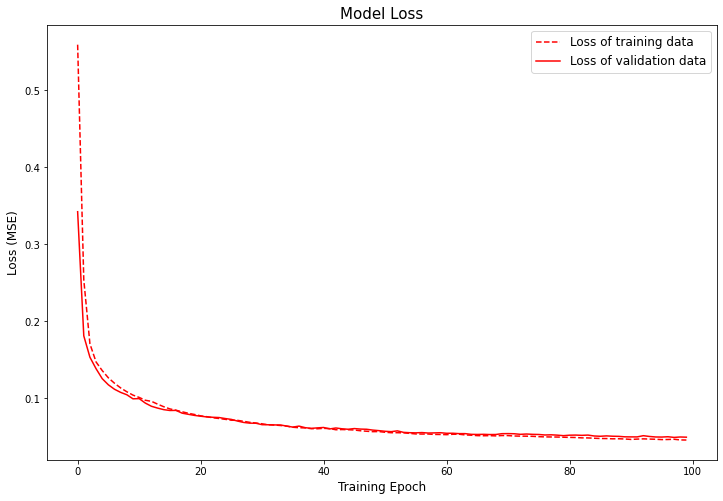

In [18]:
plt.figure(figsize=(12, 8))                                                     
plt.plot(history.history['loss'], "r--", label="Loss of training data", antialiased=True)
plt.plot(history.history['val_loss'], "r", label="Loss of validation data", antialiased=True)
plt.title('Model Loss',fontsize=15)                                            
plt.ylabel('Loss (MSE)', fontsize=12)                                                 
plt.xlabel('Training Epoch', fontsize=12)                                                                                                                       
plt.legend(fontsize=12)                                                                    
plt.show()     

In [19]:
#del x_train

import gc
gc.collect()

14845

In [20]:
autoencoder.save("latest_models/model_AE_" + wireplane + "plane_nu.h5")

In [21]:
autoencoder.evaluate(x_test_scaled, y_test_scaled, batch_size=4096)

25/25 [==============================] - 0s 8ms/step - loss: 0.0588


0.05882152169942856

In [22]:
%%time
y = autoencoder.predict(x_test_scaled, batch_size=4096)

25/25 [==============================] - 0s 5ms/step
Wall time: 470 ms


In [23]:
y = y.reshape(y.shape[0], y.shape[1])
#y = std*y + mean

In [24]:
#y_test_rescaled = std*y_test_scaled + mean

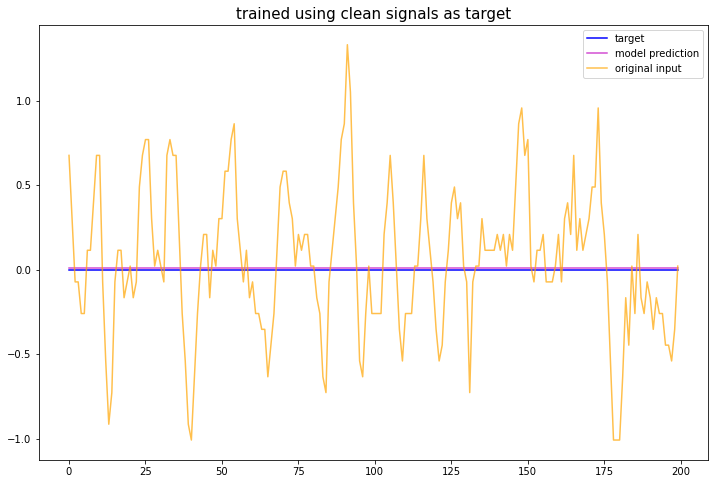

0.00819888524711132
9.313226e-10


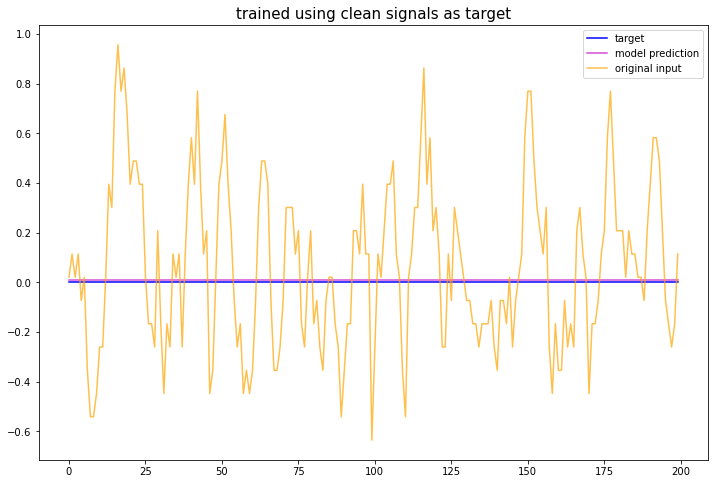

0.00819888524711132
9.313226e-10


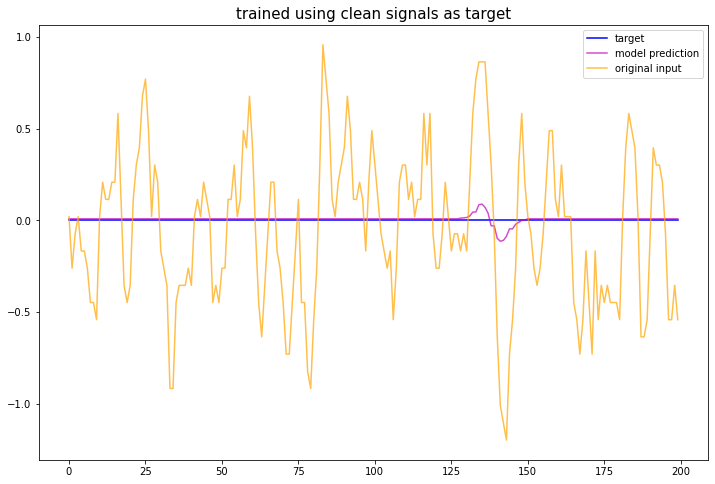

0.006530568557791412
0.019869423


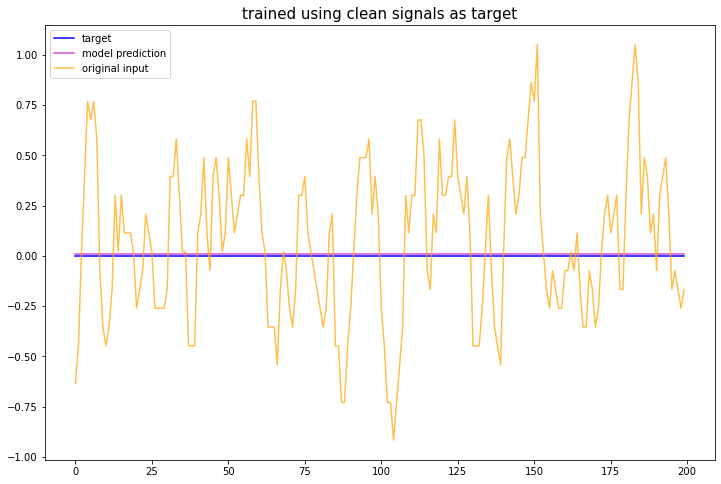

0.00819888524711132
9.313226e-10


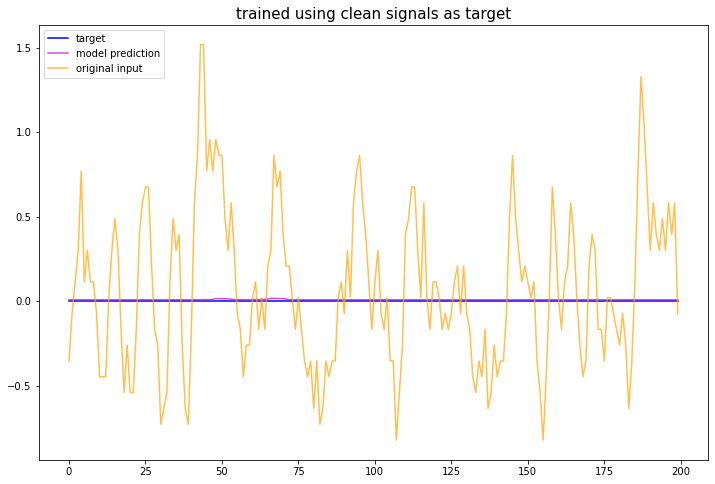

0.008691392652690411
0.0016181333


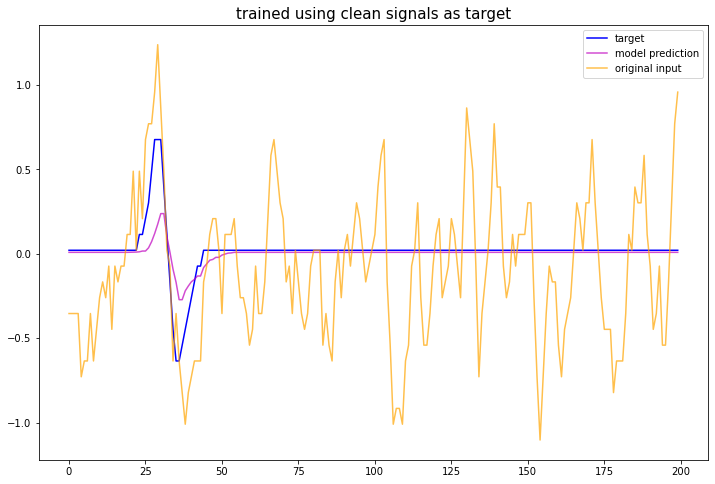

0.001810006774030626
0.05268267


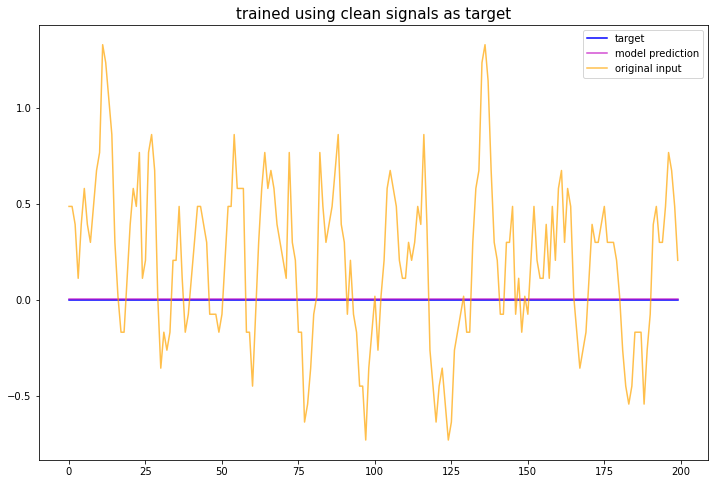

0.00819888524711132
9.313226e-10


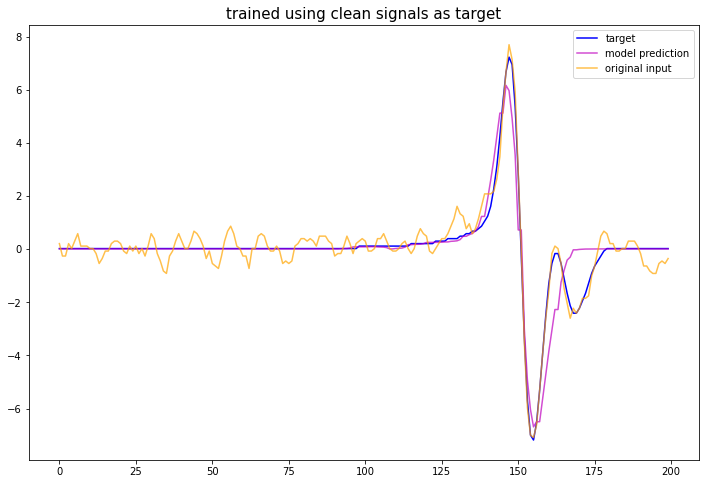

-0.005990254073403776
1.5810138


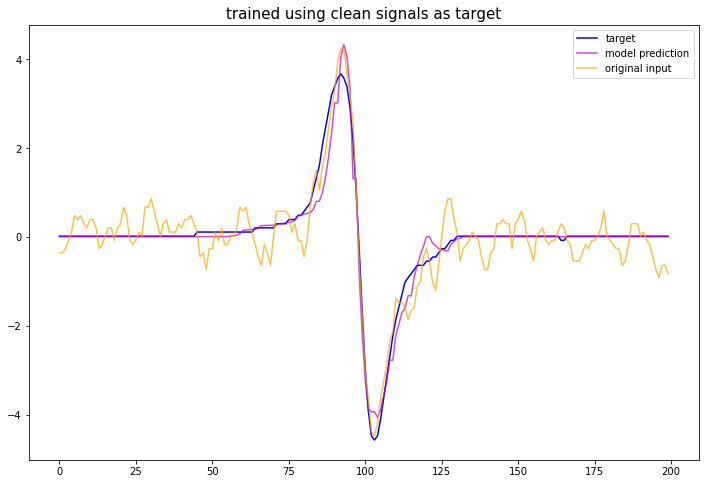

-0.05378411553800106
1.1207602


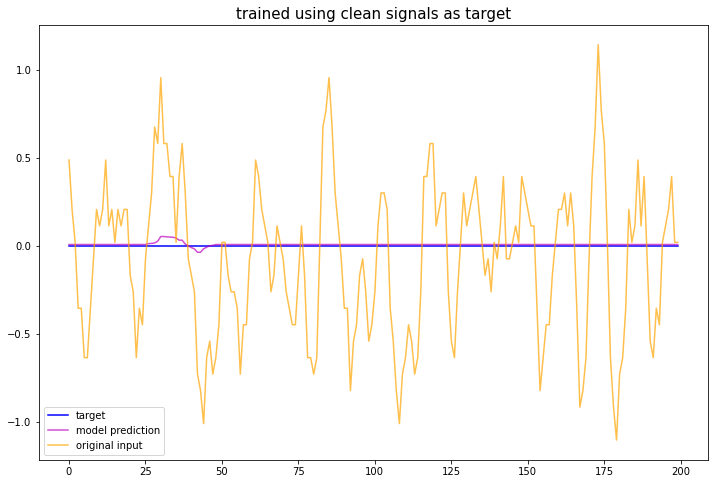

0.008981721987947822
0.009558675


In [25]:
for idx in range(10):
    fig, (ax1) = plt.subplots(figsize=(12, 8), facecolor='white')
    ax1.plot(y_test_scaled[idx],color='blue', label='target')
    ax1.plot(y[idx],color='m',alpha=0.7, label='model prediction')
    ax1.plot(x_test_scaled[idx], color='orange',alpha=0.7, label = 'original input')
    ax1.set_title("trained using clean signals as target", fontsize=15)
    ax1.legend()
    

    plt.show()
    print(sum(y[idx])/len(y[idx]))
    print(y[idx].std())